In [1]:
import numpy as np   #科学计数库
import pandas as pd  #基于Numpy的Python数据分析工具，提供了高效的数据结构和数据分析工具
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score    #可以使用这两个函数比较回归模型性能，评估模型的拟合程度和预测精度
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import confusion_matrix
import timm
import torch #提供了许多深度学习任务的函数和类
from torch import nn, optim #nn用于定义神经网络层和模型,optim用于定义各种优化算法
from torch.utils.data import DataLoader, Dataset  #使用DataLoader, Dataset加载处理数据
import torchvision
from torchvision import datasets, transforms  #通过导入可以方便的访问和使用现有的计算机视觉数据集，并对数据进行预处理以满足模型训练的需求
from transformers import ViTForImageClassification, ViTFeatureExtractor
from torchvision import models
from datetime import datetime
from tqdm import tqdm    #tqdm用于创建进度条的库，可以在循环中显示进度条，方便用户实时了解任务的完成情况
import matplotlib.pyplot as plt            #Python中的一个绘图库，提供了各种绘图函数和工具，可以用各种类型图形和可视化结果
import scipy.io as scio              #读取和写入MATLAB格式的数据文件（.mat文件）
from sklearn.metrics import classification_report 
from itertools import cycle
from sklearn.preprocessing import label_binarize    #都属于sklearn库中metrics模块和preprocessing模块，用于评估二分类模型的性能
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import os
from torchvision.utils import save_image
import math
import shutil
import random
import glob
from PIL import Image
import cv2
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib
import xlrd 

In [5]:
# 读取三个 CSV 文件  
train_file_path = "D:\\甲状腺\\数据集新 - 副本重组\\train.csv"
valid_file_path = "D:\\甲状腺\\数据集新 - 副本重组\\valid.csv"
test_file_path = "D:\\甲状腺\\数据集新 - 副本重组\\test.csv"

train_data = pd.read_csv(train_file_path)  
valid_data = pd.read_csv(valid_file_path)
test_data = pd.read_csv(test_file_path)


In [49]:
class CustomDataset(Dataset):  
    def __init__(self, dataframe, transform=None):  
        self.dataframe = dataframe  
        self.transform = transform  

    def __len__(self):  
        return len(self.dataframe)  

    def __getitem__(self, idx):  
        img_path = self.dataframe.iloc[idx]['image_path'] 
        image = Image.open(img_path)  
        age = self.dataframe.iloc[idx]['age']  
        gender = self.dataframe.iloc[idx]['gender']  
        Nodules_num = self.dataframe.iloc[idx]['Nodules_num'] 
        labels=self.dataframe.iloc[idx]['labels']
        Nodule_size_length=self.dataframe.iloc[idx]['Nodule_size_length']
        Nodule_size_wide=self.dataframe.iloc[idx]['Nodule_size_wide']
        Nodule_size_depth=self.dataframe.iloc[idx]['Nodule_size_depth']
        
        if self.transform:  
            image = self.transform(image)  
        
        return image, torch.tensor([age,gender,Nodules_num,Nodule_size_length,Nodule_size_wide,Nodule_size_depth],dtype=torch.float32), labels

In [89]:
# 图像转换  
transform = transforms.Compose([  
    transforms.Resize((224, 224)),  
    transforms.ToTensor()  
])  

# 直接从三个CSV文件创建数据集
train_dataset = CustomDataset(train_data, transform=transform)     
valid_dataset = CustomDataset(valid_data, transform=transform)
test_dataset = CustomDataset(test_data, transform=transform)

# 创建 DataLoader 加载数据
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 打印数据集信息
print(f"\n训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(valid_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

print(f"训练集批次: {len(train_loader)}")
print(f"验证集批次: {len(valid_loader)}")
print(f"测试集批次: {len(test_loader)}")

# 打印类别分布
def print_label_distribution(dataset, dataset_name):
    print(f"\n{dataset_name}标签分布:")
    label_counts = {}
    for i in range(len(dataset)):
        _, _, label = dataset[i]
        label_counts[label] = label_counts.get(label, 0) + 1
    
    for label in sorted(label_counts.keys()):
        print(f"  标签 {label}: {label_counts[label]} 个样本")

print_label_distribution(train_dataset, "训练集")
print_label_distribution(valid_dataset, "验证集")
print_label_distribution(test_dataset, "测试集")

训练集样本数: 619
验证集样本数: 59
测试集样本数: 60

=== 各类别数据分布 ===

训练集类别分布:
  类别 0: 84 个样本
  类别 1: 87 个样本
  类别 2: 112 个样本
  类别 3: 84 个样本
  类别 4: 84 个样本
  类别 5: 84 个样本
  类别 6: 84 个样本

验证集类别分布:
  类别 0: 8 个样本
  类别 1: 8 个样本
  类别 2: 11 个样本
  类别 3: 8 个样本
  类别 4: 8 个样本
  类别 5: 8 个样本
  类别 6: 8 个样本

测试集类别分布:
  类别 0: 8 个样本
  类别 1: 9 个样本
  类别 2: 11 个样本
  类别 3: 8 个样本
  类别 4: 8 个样本
  类别 5: 8 个样本
  类别 6: 8 个样本

=== 数据集所有图片路径 ===

训练集所有图片路径 (619张):
  样本 1: D:\\甲状腺\\新数据集-分7类\\1类\\image_1class_5.jpg (标签: 0)
  样本 2: D:\\甲状腺\\新数据集-分7类\\4c类\\image_4Cclass_25.jpg (标签: 5)
  样本 3: D:\\甲状腺\\新数据集-分7类\\4a类\\image_4Aclass_52.jpg (标签: 3)
  样本 4: D:\\甲状腺\\新数据集-分7类\\3类\\image_3class_91.jpg (标签: 2)
  样本 5: D:\\甲状腺\\新数据集-分7类\\2类\\image_2class_47.jpg (标签: 1)
  样本 6: D:\\甲状腺\\新数据集-分7类\\4c类\\image_4Cclass_96.jpg (标签: 5)
  样本 7: D:\\甲状腺\\新数据集-分7类\\3类\\image_3class_121.jpg (标签: 2)
  样本 8: D:\\甲状腺\\新数据集-分7类\\3类\\image_3class_79.jpg (标签: 2)
  样本 9: D:\\甲状腺\\新数据集-分7类\\4b类\\image_4bclass_49.jpg (标签: 4)
  样本 10: D:\\甲状腺\\新数据集-分7类\\4a类\\image

In [53]:
examples = enumerate(train_loader) #img&label，将train_loader转换为一个可枚举的对象examples，以便能够对其进行迭代，返回的是一个迭代器
batch_idx, (imgs,text_features,labels) = next(examples) #读取数据,batch_idx从0开始
print(batch_idx)  #批次索引
print(imgs.shape)  #图像数据的形状
print(text_features)#文本特征
print(labels) #读取标签数据

0
torch.Size([32, 3, 224, 224])
tensor([[67.0000,  1.0000,  1.0000, 11.7000, 10.7000, 11.9000],
        [36.0000,  1.0000,  1.0000,  2.8000,  2.4000,  2.9000],
        [45.0000,  1.0000,  1.0000,  5.0000,  4.9000,  7.3000],
        [39.0000,  0.0000,  2.0000,  0.0000,  0.0000,  0.0000],
        [34.0000,  1.0000,  1.0000, 35.0000, 16.0000,  7.0000],
        [33.0000,  1.0000,  1.0000,  8.0000,  7.0000,  5.0000],
        [50.0000,  1.0000,  1.0000,  6.5000,  6.6000,  3.4000],
        [38.0000,  1.0000,  2.0000,  0.0000,  0.0000,  0.0000],
        [34.0000,  1.0000,  2.0000,  0.0000,  0.0000,  0.0000],
        [49.0000,  1.0000,  1.0000,  5.2000,  6.3000,  3.0000],
        [47.0000,  1.0000,  1.0000,  3.0000,  3.0000,  2.0000],
        [52.0000,  0.0000,  2.0000,  0.0000,  0.0000,  0.0000],
        [70.0000,  1.0000,  1.0000, 24.9000, 30.3000, 24.3000],
        [64.0000,  1.0000,  0.0000, 13.9000, 19.9000,  9.3000],
        [46.0000,  1.0000,  0.0000,  2.5000,  2.4000,  4.5000],
        

In [55]:
class CombinedModel(nn.Module):  
    def __init__(self):  
        super(CombinedModel, self).__init__()  
        # 图像特征提取
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Identity()  # 去掉最后的全连接层
        
        # 特征融合层
        self.fusion = nn.Sequential(
            nn.Linear(512 + 6, 256),  # 512（图像特征） + 6（非图像特征）
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        
        # 分类头
        self.classifier = nn.Linear(256, 7)
        
        # 对比学习投影头
        self.projector = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)  # 最终投影到64维空间
        )
        
        # 存储特征图的钩子
        self.feature_maps = None
        self.gradients = None
        
        # 为layer4注册钩子
        self.resnet.layer4.register_forward_hook(self.save_feature_maps)
        self.resnet.layer4.register_backward_hook(self.save_gradients)
        
    def save_feature_maps(self, module, input, output):
        """保存前向传播的特征图"""
        self.feature_maps = output
        
    def save_gradients(self, module, grad_input, grad_output):
        """保存反向传播的梯度"""
        self.gradients = grad_output[0]
        
    def forward(self, image, text_features):  
        # 图像特征提取 [bs, 512]
        image_features = self.resnet(image)
        
        # 特征融合
        combined = torch.cat([image_features, text_features], dim=1)
        fused = self.fusion(combined)
        
        # 分类输出
        logits = self.classifier(fused)
        
        # 对比特征
        projections = self.projector(fused)
        return logits, projections
    
    def get_feature_maps(self):
        """获取特征图"""
        return self.feature_maps
    
    def get_gradients(self):
        """获取梯度"""
        return self.gradients

model = CombinedModel()

D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [57]:
def compute_grad_cam(model, image, text_features, target_class=None):
    """
    计算Grad-CAM热力图
    :param model: 模型实例
    :param image: 输入图像 (1, C, H, W)
    :param text_features: 文本特征 (1, 6)
    :param target_class: 目标类别，None表示使用预测类别
    :return: 热力图 (H, W)
    """
    model.eval()
    
    # 前向传播
    logits, _ = model(image, text_features)
    
    # 确定目标类别
    if target_class is None:
        target_class = logits.argmax(dim=1).item()
    
    # 清零梯度
    model.zero_grad()
    
    # 计算目标类别的梯度
    target = torch.zeros_like(logits)
    target[0, target_class] = 1
    logits.backward(gradient=target)
    
    # 获取特征图和梯度
    features = model.get_feature_maps()
    gradients = model.get_gradients()
    
    # 计算权重 (对梯度在空间维度求平均)
    pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True)
    
    # 加权特征图
    weighted_features = features * pooled_gradients
    
    # 在通道维度求和并应用ReLU
    heatmap = torch.sum(weighted_features, dim=1, keepdim=True)
    heatmap = torch.relu(heatmap)
    
    # 归一化到0-1范围
    heatmap -= heatmap.min()
    heatmap /= heatmap.max()
    
    # 调整大小到原始图像尺寸
    heatmap = F.interpolate(heatmap, size=image.shape[2:], mode='bilinear', align_corners=False)
    
    return heatmap.squeeze().cpu().detach().numpy(), target_class

In [59]:
def visualize_grad_cam(image, heatmap, alpha=0.5):
    """
    可视化Grad-CAM热力图
    :param image: 原始图像 (C, H, W)
    :param heatmap: 热力图 (H, W)
    :param alpha: 热力图透明度
    :return: 叠加后的图像
    """
    # 转换为numpy数组
    image_np = image.permute(1, 2, 0).cpu().numpy()
    
    # 归一化图像
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min())
    
    # 创建热力图
    heatmap = np.uint8(255 * heatmap)
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    
    # 创建叠加图像
    jet_heatmap = np.uint8(255 * jet_heatmap)
    jet_heatmap = cv2.resize(jet_heatmap, (image.shape[2], image.shape[1]))
    superimposed_img = jet_heatmap * alpha + image_np * (1 - alpha)
    superimposed_img = np.clip(superimposed_img, 0, 1)
    
    return superimposed_img

In [61]:
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, projections, labels):
        # 归一化特征
        projections = nn.functional.normalize(projections, p=2, dim=1)
        
        # 计算相似度矩阵
        sim_matrix = torch.matmul(projections, projections.T) / self.temperature
        
        # 创建正样本掩码（相同标签且非自身）
        labels = labels.view(-1, 1)
        mask = torch.eq(labels, labels.T).float()
        self_mask = torch.eye(labels.size(0), device=labels.device)
        mask = mask * (1 - self_mask)  # 排除自身
        
        # 计算对比损失
        exp_sim = torch.exp(sim_matrix)
        log_prob = sim_matrix - torch.log(exp_sim.sum(dim=1, keepdim=True))
        
        # 计算正样本的平均log概率
        mean_log_prob = (mask * log_prob).sum(1) / (mask.sum(1) + 1e-8)
        loss = -mean_log_prob.mean()
        
        return loss

In [63]:
criterion_cls = nn.CrossEntropyLoss()
criterion_scl = SupConLoss(temperature=0.07)
# 优化器配置
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)

In [65]:
class EarlyStopping:
    def __init__(self, patience=100, delta=0.001, verbose=10, path='checkpoint.pt', trace_func=print):
        self.patience = patience  # 容忍的等待次数
        self.delta = delta  # 验证集上的性能提升的阈值
        self.verbose = verbose  # 是否输出提示信息
        self.path = path  # 保存模型的路径
        self.trace_func = trace_func  # 输出信息的函数
        self.counter = 0  # 等待次数计数
        self.best_score = None  # 最好的验证集性能
        self.early_stop = False  # 是否早停
        self.val_loss_min = np.Inf  # 最小的验证集损失

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [67]:
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib as mpl
from sklearn.metrics import roc_curve, auc
import numpy as np

def train_with_early_stopping(model, train_loader, criterion, optimizer, num_epochs, valid_loader, early_stopper=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # 新增对比损失和权重参数
    criterion_scl = SupConLoss(temperature=0.07)
    lambda_scl = 0.1   # 对比损失权重
    criterion_cls = criterion  # 修复变量名错误

    loss_list = []
    val_loss_list = []
    accuracy_list = []
    best_accuracy = 0.0
    best_val_loss = 0.0
    
    fpr = {}  
    tpr = {}  
    roc_auc = {}  
    num_classes = 7

    # 修改日志列：添加宏观平均指标
    log_columns = ['epoch', 'loss', 'val_loss', 'Total_ACC', 'Pmacro', 'Rmacro', 'F1macro']
    for i in range(num_classes):
        log_columns.extend([
            f'Class{i}_ACC',    # 准确率
            f'Class{i}_PRE',    # 精确率
            f'Class{i}_SPE',    # 特异性
            f'Class{i}_SEN',    # 敏感性
            f'Class{i}_F1'      # F1指标
        ])
    log_df = pd.DataFrame(columns=log_columns)
    
    for epoch in range(num_epochs):
        model.train()
        sum_loss = 0.0
        
        for batch_idx, (images, text_features, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)  
            text_features = text_features.to(device)
            
            optimizer.zero_grad()
            
            # 前向传播（获取两个输出）
            logits, projections = model(images, text_features)
            
            # 计算双重损失
            cls_loss = criterion(logits, labels)
            scl_loss = criterion_scl(projections, labels)
            total_loss = cls_loss + lambda_scl * scl_loss
            
            # 反向传播
            total_loss.backward()
            optimizer.step()
            
            sum_loss += total_loss.item()

        epoch_loss = sum_loss / len(train_loader) 
        loss_list.append(epoch_loss) 
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}') 

        # Validate model performance
        if valid_loader is not None:
            model.eval()
            val_sum_loss = 0.0
            correct = 0
            total = 0

            y_true = []  
            y_scores = []  

            all_preds = []
            all_labels = []
        
            with torch.no_grad():
                for images, text_features, labels in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    text_features = text_features.to(device)
                    
                    # 修改点3：验证阶段也需要解包
                    logits, _ = model(images, text_features)  # 不需要projections
                    
                    val_loss = criterion_cls(logits, labels)
                    val_sum_loss += val_loss.item()
                    _, predicted = torch.max(logits.data, 1)

                    all_preds.extend(predicted.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    probs = torch.softmax(logits, dim=1)
                    y_true.extend(labels.cpu().numpy())
                    y_scores.extend(probs.cpu().numpy())

                # 将扩展后的列表转换为numpy数组  
                y_true = np.array(y_true)  
                y_scores = np.array(y_scores)  

                
                val_loss =  val_sum_loss / len(valid_loader)
                val_loss_list.append(val_loss)
                accuracy = 100*correct / total
                accuracy_list.append(accuracy)    
                print('Validation Loss: {:.4f}, Validation Accuracy: {:.2f}'.format(val_loss, accuracy)) 
                
                # Check for early stopping using validation accuracy 
                if early_stopper : 
                    early_stopper(val_loss, model) 
                    if early_stopper.early_stop: 
                        print("Early stopping") 
                        break 
                        
                # Save the best model based on validation accuracy 
                if accuracy > best_accuracy: 
                    best_accuracy = accuracy 
                    best_model_state = model.state_dict() 

             # 计算混淆矩阵
            cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
            class_pre_list = []  # 存储每个类别的精确率
            class_rec_list = []  # 存储每个类别的召回率
            class_f1_list = []   # 存储每个类别的F1
            class_spe_list = []  # 存储每个类别的特异性
            class_acc_list = []  # 存储每个类别的准确率
            
            # 计算每个类别的指标
            for i in range(num_classes):
                TP = cm[i, i]
                FP = cm[:, i].sum() - TP
                FN = cm[i, :].sum() - TP
                TN = cm.sum() - (TP + FP + FN)
                
                eps = 1e-6
                PRE = TP / (TP + FP + eps)  # 精确率
                REC = TP / (TP + FN + eps)  # 召回率/敏感性
                SPE = TN / (TN + FP + eps)  # 特异性
                ACC = (TP + TN) / (TP + TN + FP + FN + eps)  # 类别准确率
                F1 = (2 * PRE * REC) / (PRE + REC + eps)  # F1得分
                
                class_pre_list.append(PRE)
                class_rec_list.append(REC)
                class_f1_list.append(F1)
                class_spe_list.append(SPE)
                class_acc_list.append(ACC)
            
            # 计算宏观平均指标
            Pmacro = np.mean(class_pre_list)  # 宏观平均精确率
            Rmacro = np.mean(class_rec_list)  # 宏观平均召回率
            F1macro = np.mean(class_f1_list)  # 宏观平均F1
            
            # 创建日志字典
            epoch_metrics = {
                'epoch': round(epoch+1, 5),
                'loss': round(epoch_loss, 5),
                'val_loss': round(val_loss, 5),
                'Total_ACC': round(accuracy, 5),  # 总体准确率
                'Pmacro': round(Pmacro, 5),
                'Rmacro': round(Rmacro, 5),
                'F1macro': round(F1macro, 5)
            }
            
            # 添加每个类别的指标
            for i in range(num_classes):
                epoch_metrics.update({
                    f'Class{i}_ACC': round(class_acc_list[i], 5),
                    f'Class{i}_PRE': round(class_pre_list[i], 5),
                    f'Class{i}_SPE': round(class_spe_list[i], 5),
                    f'Class{i}_SEN': round(class_rec_list[i], 5),  # SEN即召回率
                    f'Class{i}_F1': round(class_f1_list[i], 5)
                })
                
            
            
            # 使用pd.concat代替append
            new_row_df = pd.DataFrame([epoch_metrics])
            log_df = pd.concat([log_df, new_row_df], ignore_index=True)
        
            # 保存到CSV（每个epoch追加模式）
            if epoch == 0:
                log_df.to_csv('模型数据resnet18分7类.csv', index=False)
            else:
                log_df.tail(1).to_csv('模型数据resnet18分7类.csv', mode='a', header=False, index=False)
        
        
    # Load the best model state 
    if 'best_model_state' in locals(): 
        model.load_state_dict(best_model_state) 
        
    # 设置全局字体为新罗马（Times New Roman）
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Times New Roman']
    plt.rcParams['font.size'] = 18  # 设置全局字体大小
    
    # Plot the training and validation loss 
    plt.figure(figsize=(6.5, 5)) 
    plt.plot(range(len(loss_list)), loss_list, "r-", label="Training Loss", linewidth=2) 
    plt.plot(range(len(val_loss_list)), val_loss_list, "b-", label="Validation Loss", linewidth=2) 
    plt.xticks(fontname='Times New Roman', fontsize=18)
    plt.yticks(fontname='Times New Roman', fontsize=18)
    plt.xlabel("Epochs", fontname='Times New Roman', fontsize=18)  # 修改x轴标签字体
    plt.ylabel("Loss", fontname='Times New Roman', fontsize=18)    # 修改y轴标签字体
    plt.legend(prop={'family': 'Times New Roman', 'size': 16}) 
    plt.title("Training and Validation Loss", fontname='Times New Roman', fontsize=18) 
    plt.grid(True) 
    
    # 保存损失曲线图
    plt.savefig('loss_curve-7.jpg', dpi=300, bbox_inches='tight')
    plt.show() 
    
    # Plot the validation accuracy 
    plt.figure(figsize=(6.5, 5)) 
    plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, "b-", linewidth=2) 
    plt.xticks(fontname='Times New Roman', fontsize=18)
    plt.yticks(fontname='Times New Roman', fontsize=18)
    plt.xlabel("Epochs", fontname='Times New Roman', fontsize=18)  # 修改x轴标签字体
    plt.ylabel("Accuracy (%)", fontname='Times New Roman', fontsize=18)  # 修改y轴标签字体
    plt.title("Validation Accuracy Over Epochs", fontname='Times New Roman', fontsize=18) 
    plt.grid(True) 
    
    # 保存准确率曲线图
    plt.savefig('accuracy_curve-7.jpg', dpi=300, bbox_inches='tight')
    plt.show()

    # 将真实标签进行二值化处理  
    classes_to_keep = [0, 1, 2, 3, 4, 5, 6] 
    y_true_bin = label_binarize(y_true, classes=classes_to_keep)  
    n_classes = y_true_bin.shape[1] 
    
    # 定义类别名称
    class_names = {
        0: "class 1  ",
        1: "class 2  ",
        2: "class 3  ",
        3: "class 4a",
        4: "class 4b",
        5: "class 4c",
        6: "class 5  "
    }
    
    plt.figure(figsize=(6.5, 6))

    # 绘制ROC曲线 (加粗曲线)
    for i in range(n_classes):  
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])  
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, linewidth=3, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')  
    
    # 绘制对角线
    plt.plot([0, 1], [0, 1], 'k--', lw=2) 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    
    # 设置标签 - 加粗所有文本
    plt.xlabel('1 - Specificity', fontname='Times New Roman', fontsize=18, fontweight='bold')  # 修改字体
    plt.ylabel('Sensitivity', fontname='Times New Roman', fontsize=18, fontweight='bold')    # 修改字体

    
    # 设置图例 - 加粗
    plt.legend(loc="lower right", prop={'family': 'Times New Roman', 'size': 16, 'weight': 'bold'})
    
    # 设置刻度标签字体 - 加粗
    plt.xticks(fontname='Times New Roman', fontsize=18, fontweight='bold')
    plt.yticks(fontname='Times New Roman', fontsize=18, fontweight='bold')
    
    # 设置坐标轴加粗
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.5)  # 坐标轴线宽加粗
    
    # 保存和显示
    plt.tight_layout()
    plt.savefig('roc_curve-7.jpg', dpi=300, bbox_inches='tight')
    plt.show()

D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 1/300, Loss: 2.5490
Validation Loss: 1.7767, Validation Accuracy: 32.20
Validation loss decreased (inf --> 1.776677).  Saving model ...


C:\Users\ccl\AppData\Local\Temp\ipykernel_90292\1997904629.py:185: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  log_df = pd.concat([log_df, new_row_df], ignore_index=True)
D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 2/300, Loss: 2.1020
Validation Loss: 1.5793, Validation Accuracy: 33.90
Validation loss decreased (1.776677 --> 1.579270).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 3/300, Loss: 1.9320
Validation Loss: 1.4498, Validation Accuracy: 64.41
Validation loss decreased (1.579270 --> 1.449790).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 4/300, Loss: 1.8181
Validation Loss: 1.3377, Validation Accuracy: 49.15
Validation loss decreased (1.449790 --> 1.337659).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 5/300, Loss: 1.6943
Validation Loss: 1.2074, Validation Accuracy: 72.88
Validation loss decreased (1.337659 --> 1.207359).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 6/300, Loss: 1.5604
Validation Loss: 1.1157, Validation Accuracy: 64.41
Validation loss decreased (1.207359 --> 1.115669).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 7/300, Loss: 1.4444
Validation Loss: 1.0084, Validation Accuracy: 71.19
Validation loss decreased (1.115669 --> 1.008360).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 8/300, Loss: 1.3459
Validation Loss: 0.9245, Validation Accuracy: 74.58
Validation loss decreased (1.008360 --> 0.924455).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 9/300, Loss: 1.1503
Validation Loss: 0.8188, Validation Accuracy: 76.27
Validation loss decreased (0.924455 --> 0.818810).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 10/300, Loss: 1.0451
Validation Loss: 0.6983, Validation Accuracy: 81.36
Validation loss decreased (0.818810 --> 0.698312).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 11/300, Loss: 0.9198
Validation Loss: 0.5908, Validation Accuracy: 86.44
Validation loss decreased (0.698312 --> 0.590810).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 12/300, Loss: 0.7384
Validation Loss: 0.5025, Validation Accuracy: 88.14
Validation loss decreased (0.590810 --> 0.502529).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 13/300, Loss: 0.6706
Validation Loss: 0.4817, Validation Accuracy: 89.83
Validation loss decreased (0.502529 --> 0.481737).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 14/300, Loss: 0.6173
Validation Loss: 0.4681, Validation Accuracy: 86.44
Validation loss decreased (0.481737 --> 0.468087).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 15/300, Loss: 0.5327
Validation Loss: 0.4280, Validation Accuracy: 86.44
Validation loss decreased (0.468087 --> 0.427996).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 16/300, Loss: 0.4683
Validation Loss: 0.4106, Validation Accuracy: 86.44
Validation loss decreased (0.427996 --> 0.410628).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 17/300, Loss: 0.4422
Validation Loss: 0.3879, Validation Accuracy: 88.14
Validation loss decreased (0.410628 --> 0.387865).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 18/300, Loss: 0.4068
Validation Loss: 0.3594, Validation Accuracy: 89.83
Validation loss decreased (0.387865 --> 0.359385).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 19/300, Loss: 0.3859
Validation Loss: 0.3708, Validation Accuracy: 88.14
EarlyStopping counter: 1 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 20/300, Loss: 0.3850
Validation Loss: 0.3719, Validation Accuracy: 89.83
EarlyStopping counter: 2 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 21/300, Loss: 0.3510
Validation Loss: 0.3521, Validation Accuracy: 86.44
Validation loss decreased (0.359385 --> 0.352077).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 22/300, Loss: 0.3450
Validation Loss: 0.3518, Validation Accuracy: 88.14
EarlyStopping counter: 1 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 23/300, Loss: 0.3199
Validation Loss: 0.3756, Validation Accuracy: 86.44
EarlyStopping counter: 2 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 24/300, Loss: 0.3099
Validation Loss: 0.3394, Validation Accuracy: 88.14
Validation loss decreased (0.352077 --> 0.339432).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 25/300, Loss: 0.3104
Validation Loss: 0.3736, Validation Accuracy: 84.75
EarlyStopping counter: 1 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 26/300, Loss: 0.3084
Validation Loss: 0.3421, Validation Accuracy: 88.14
EarlyStopping counter: 2 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 27/300, Loss: 0.2890
Validation Loss: 0.3684, Validation Accuracy: 84.75
EarlyStopping counter: 3 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 28/300, Loss: 0.2872
Validation Loss: 0.3540, Validation Accuracy: 89.83
EarlyStopping counter: 4 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 29/300, Loss: 0.2699
Validation Loss: 0.3954, Validation Accuracy: 86.44
EarlyStopping counter: 5 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 30/300, Loss: 0.2672
Validation Loss: 0.3408, Validation Accuracy: 89.83
EarlyStopping counter: 6 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 31/300, Loss: 0.2558
Validation Loss: 0.3546, Validation Accuracy: 88.14
EarlyStopping counter: 7 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 32/300, Loss: 0.2655
Validation Loss: 0.3500, Validation Accuracy: 88.14
EarlyStopping counter: 8 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 33/300, Loss: 0.2514
Validation Loss: 0.3591, Validation Accuracy: 89.83
EarlyStopping counter: 9 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 34/300, Loss: 0.2516
Validation Loss: 0.3686, Validation Accuracy: 86.44
EarlyStopping counter: 10 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 35/300, Loss: 0.2509
Validation Loss: 0.3548, Validation Accuracy: 88.14
EarlyStopping counter: 11 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 36/300, Loss: 0.2455
Validation Loss: 0.3234, Validation Accuracy: 89.83
Validation loss decreased (0.339432 --> 0.323397).  Saving model ...


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 37/300, Loss: 0.2385
Validation Loss: 0.3481, Validation Accuracy: 88.14
EarlyStopping counter: 1 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 38/300, Loss: 0.2389
Validation Loss: 0.3544, Validation Accuracy: 88.14
EarlyStopping counter: 2 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 39/300, Loss: 0.2397
Validation Loss: 0.3234, Validation Accuracy: 89.83
EarlyStopping counter: 3 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 40/300, Loss: 0.2327
Validation Loss: 0.3713, Validation Accuracy: 89.83
EarlyStopping counter: 4 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 41/300, Loss: 0.2291
Validation Loss: 0.3460, Validation Accuracy: 88.14
EarlyStopping counter: 5 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 42/300, Loss: 0.2224
Validation Loss: 0.3659, Validation Accuracy: 88.14
EarlyStopping counter: 6 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 43/300, Loss: 0.2250
Validation Loss: 0.3278, Validation Accuracy: 88.14
EarlyStopping counter: 7 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 44/300, Loss: 0.2270
Validation Loss: 0.3264, Validation Accuracy: 88.14
EarlyStopping counter: 8 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 45/300, Loss: 0.2246
Validation Loss: 0.3700, Validation Accuracy: 84.75
EarlyStopping counter: 9 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 46/300, Loss: 0.2291
Validation Loss: 0.3808, Validation Accuracy: 88.14
EarlyStopping counter: 10 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 47/300, Loss: 0.2212
Validation Loss: 0.3891, Validation Accuracy: 86.44
EarlyStopping counter: 11 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 48/300, Loss: 0.2188
Validation Loss: 0.3822, Validation Accuracy: 86.44
EarlyStopping counter: 12 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 49/300, Loss: 0.2124
Validation Loss: 0.4133, Validation Accuracy: 84.75
EarlyStopping counter: 13 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 50/300, Loss: 0.2152
Validation Loss: 0.3620, Validation Accuracy: 88.14
EarlyStopping counter: 14 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 51/300, Loss: 0.2159
Validation Loss: 0.3480, Validation Accuracy: 89.83
EarlyStopping counter: 15 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 52/300, Loss: 0.2223
Validation Loss: 0.3877, Validation Accuracy: 88.14
EarlyStopping counter: 16 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 53/300, Loss: 0.2135
Validation Loss: 0.3765, Validation Accuracy: 84.75
EarlyStopping counter: 17 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 54/300, Loss: 0.2141
Validation Loss: 0.3895, Validation Accuracy: 89.83
EarlyStopping counter: 18 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 55/300, Loss: 0.2169
Validation Loss: 0.3910, Validation Accuracy: 88.14
EarlyStopping counter: 19 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 56/300, Loss: 0.2158
Validation Loss: 0.3877, Validation Accuracy: 88.14
EarlyStopping counter: 20 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 57/300, Loss: 0.2037
Validation Loss: 0.4130, Validation Accuracy: 84.75
EarlyStopping counter: 21 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 58/300, Loss: 0.2055
Validation Loss: 0.4036, Validation Accuracy: 86.44
EarlyStopping counter: 22 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 59/300, Loss: 0.2026
Validation Loss: 0.4108, Validation Accuracy: 86.44
EarlyStopping counter: 23 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 60/300, Loss: 0.2066
Validation Loss: 0.4051, Validation Accuracy: 86.44
EarlyStopping counter: 24 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 61/300, Loss: 0.1957
Validation Loss: 0.4094, Validation Accuracy: 86.44
EarlyStopping counter: 25 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 62/300, Loss: 0.2002
Validation Loss: 0.4088, Validation Accuracy: 86.44
EarlyStopping counter: 26 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 63/300, Loss: 0.1977
Validation Loss: 0.4056, Validation Accuracy: 86.44
EarlyStopping counter: 27 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 64/300, Loss: 0.1989
Validation Loss: 0.3837, Validation Accuracy: 86.44
EarlyStopping counter: 28 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 65/300, Loss: 0.1962
Validation Loss: 0.3921, Validation Accuracy: 86.44
EarlyStopping counter: 29 out of 30


D:\anaconda\Lib\site-packages\torch\nn\modules\module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Epoch 66/300, Loss: 0.2005
Validation Loss: 0.4399, Validation Accuracy: 86.44
EarlyStopping counter: 30 out of 30
Early stopping


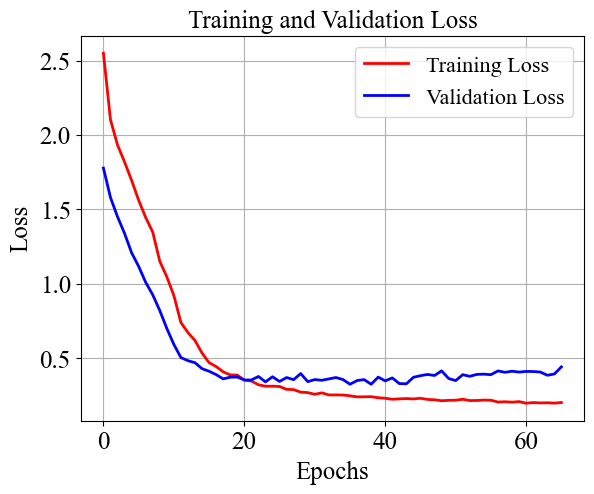

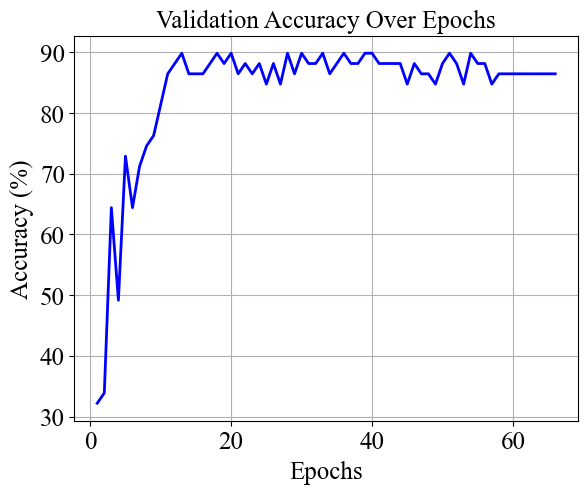

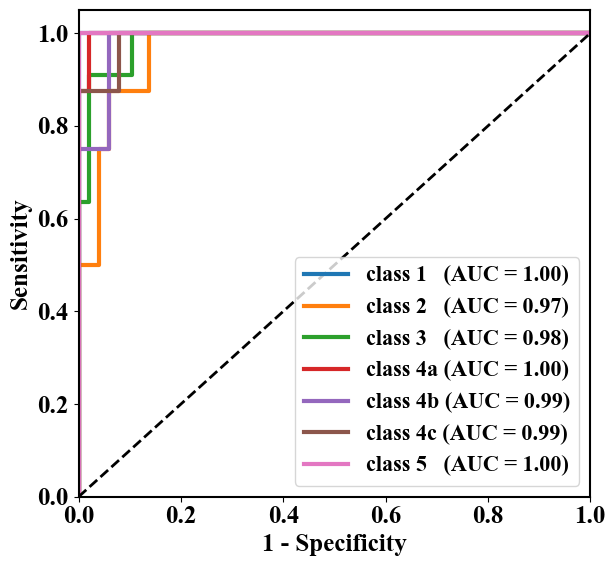

In [69]:
# 训练参数
num_epochs = 300
early_stopper = EarlyStopping(patience=30, delta=0.001, verbose=True)

# 启动训练
train_with_early_stopping(
    model, 
    train_loader, 
    criterion_cls, 
    optimizer, 
    num_epochs, 
    valid_loader, 
    early_stopper
)

In [70]:
print('Start test!')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()  # 将模型设置为评估状态
predictions = []
true_labels = []
projection_features = []  # 可选：保存对比学习特征用于可视化

with torch.no_grad():
    correct = 0
    total = 0
    for images, text_features, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)  
        text_features = text_features.to(device)
        
        # 修改点：解包模型输出
        logits, projections = model(images, text_features)  # 获取两个返回值
        
        # 保存特征用于后续分析（可选）
        projection_features.append(projections.cpu().numpy())
        
        # 只使用分类logits进行预测
        _, predicted = torch.max(logits, 1)
        
        predictions.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# 计算混淆矩阵 
conf_matrix = confusion_matrix(true_labels, predictions)

# 打印混淆矩阵 
print("Confusion Matrix:") 
print(conf_matrix)

# 打印所有批次的真实标签和所有的预测标签
print("True labels:     ", true_labels)
print("Predicted labels:", predictions)

print('Test Accuracy of the model on the test images: {:.2f}%'.format(100*correct / total))

Start test!
Confusion Matrix:
[[ 7  0  1  0  0  0  0]
 [ 1  5  1  1  0  0  1]
 [ 0  0 10  0  1  0  0]
 [ 0  1  2  5  0  0  0]
 [ 0  0  0  0  8  0  0]
 [ 0  0  0  0  0  8  0]
 [ 0  0  0  0  0  0  8]]
True labels:      [1, 4, 5, 2, 1, 2, 2, 0, 4, 5, 6, 2, 5, 2, 0, 1, 6, 2, 3, 4, 3, 3, 0, 0, 2, 6, 1, 1, 5, 0, 5, 6, 6, 4, 1, 6, 4, 5, 4, 6, 3, 5, 1, 3, 2, 4, 3, 3, 2, 2, 0, 1, 6, 2, 0, 0, 4, 3, 5, 1]
Predicted labels: [2, 4, 5, 4, 1, 2, 2, 0, 4, 5, 6, 2, 5, 2, 0, 1, 6, 2, 3, 4, 3, 3, 0, 2, 2, 6, 1, 1, 5, 0, 5, 6, 6, 4, 6, 6, 4, 5, 4, 6, 2, 5, 3, 1, 2, 4, 3, 2, 2, 2, 0, 1, 6, 2, 0, 0, 4, 3, 5, 0]
Test Accuracy of the model on the test images: 85.00%


In [15]:
torch.save(model.state_dict(), 'best_model_weights.pth')
print("模型权重已保存到 best_model_weights.pth")

模型权重已保存到 best_model_weights.pth


In [73]:
def show_cam_on_image(img: np.ndarray,
                      mask: np.ndarray,
                      use_rgb: bool = False,
                      colormap: int = cv2.COLORMAP_JET) -> np.ndarray:
    """ This function overlays the cam mask on the image as an heatmap.
    By default the heatmap is in BGR format.

    :param img: The base image in RGB or BGR format.
    :param mask: The cam mask.
    :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
    :param colormap: The OpenCV colormap to be used.
    :returns: The default image with the cam overlay.
    """

    heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)
    if use_rgb:
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = np.float32(heatmap) / 255

    if np.max(img) > 1:
        raise Exception(
            "The input image should np.float32 in the range [0, 1]")

    cam = heatmap + img
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ccl\AppData\Local\Temp\ipykernel_90292\3232410546.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for m

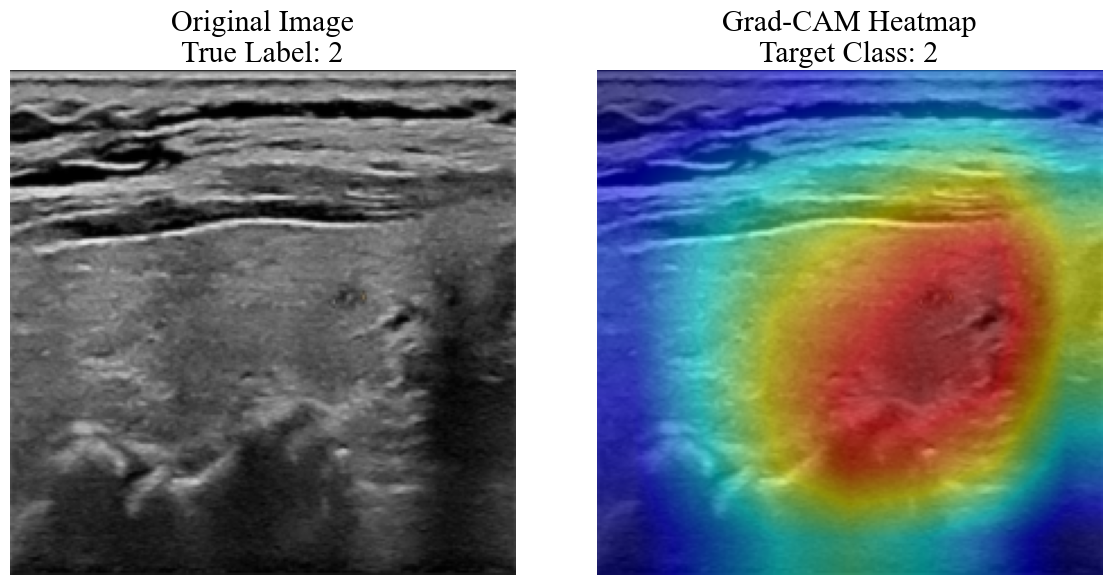

In [75]:
import torch.nn.functional as F
import cv2
import numpy as np

# 加载训练好的模型
model = CombinedModel()
model.load_state_dict(torch.load('best_model_weights.pth'))
model.eval()

# 反标准化参数（假设使用ImageNet标准）
#mean = np.array([0.485, 0.456, 0.406])
#std = np.array([0.229, 0.224, 0.225])

# 获取测试样本
images, text_features, labels = next(iter(test_loader))

# 选择单个样本
idx =5 # 选择第一个样本
image = images[idx].unsqueeze(0)  # 增加batch维度
text_feature = text_features[idx].unsqueeze(0)
label = labels[idx]

# 计算Grad-CAM
heatmap, target_class = compute_grad_cam(model, image, text_feature)

# 反标准化处理（将图像还原为0-1范围）
original_image = images[idx].cpu().detach().numpy()  # 转为numpy数组
original_image = np.transpose(original_image, (1, 2, 0))  # (H, W, C)
original_image = np.clip(original_image, 0, 1)  # 确保在[0,1]范围内

# 可视化热力图（使用与第二段代码相同的函数）
heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
visualization = show_cam_on_image(
    original_image, 
    heatmap,
    use_rgb=True
)

# 显示结果
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title(f"Original Image\nTrue Label: {label}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(visualization)
plt.title(f"Grad-CAM Heatmap\nTarget Class: {target_class}")
plt.axis('off')

plt.tight_layout()
plt.show()


In [77]:
# 创建PDF文件保存结果
from matplotlib.backends.backend_pdf import PdfPages  # 新增PDF支持

with PdfPages('grad_cam_results.pdf') as pdf:
    # 创建新图（确保与显示相同）
    fig = plt.figure(figsize=(12, 6))
    
    # 第一子图：原始图像
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(original_image)
    ax1.set_title(f"Original Image\nTrue Label: {label}")
    ax1.axis('off')
    
    # 第二子图：热力图结果
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(visualization)
    ax2.set_title(f"Grad-CAM Heatmap\nTarget Class: {target_class}")
    ax2.axis('off')
    
    plt.tight_layout()
    
    # 保存当前页到PDF
    pdf.savefig(fig, bbox_inches='tight')
    plt.close(fig)
    
print("结果已保存为 grad_cam_results.pdf")

结果已保存为 grad_cam_results.pdf


Using device: cuda


D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ccl\AppData\Local\Temp\ipykernel_90292\2030309580.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for 

Extracting training set features...
Training set features shape: (619, 256)
Extracting test set features...
Test set features shape: (60, 256)
Total features for t-SNE: 679
Running t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 679 samples in 0.000s...
[t-SNE] Computed neighbors for 679 samples in 0.146s...
[t-SNE] Computed conditional probabilities for sample 679 / 679
[t-SNE] Mean sigma: 1.303273
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.684460
[t-SNE] KL divergence after 1000 iterations: 0.168162
Saved combined t-SNE plot to combined_tsne.png


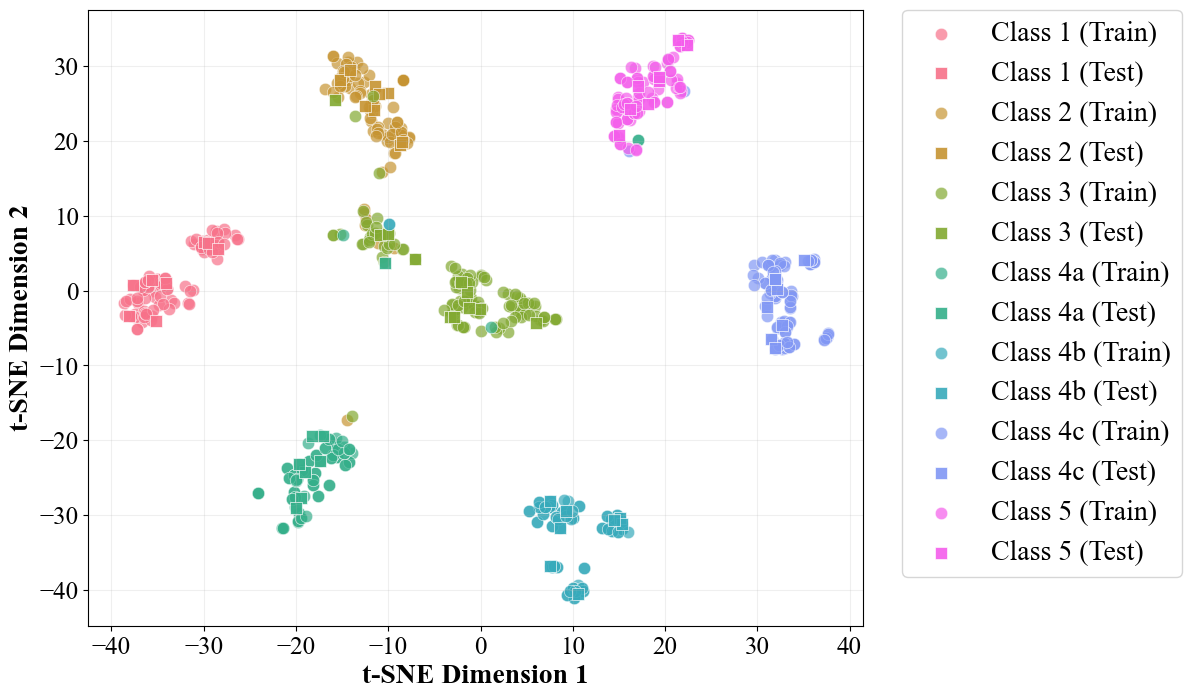

In [81]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import pandas as pd

def extract_features(model, dataloader):
    """提取融合特征层的输出特征"""
    device = next(model.parameters()).device  # 获取模型所在的设备
    model.eval()
    features = []
    labels_list = []
    
    with torch.no_grad():
        for images, text_features, labels in dataloader:
            # 将数据移动到与模型相同的设备
            images = images.to(device)
            text_features = text_features.to(device)
            
            # 提取融合特征层的输出 (256维)
            image_features = model.resnet(images)
            combined = torch.cat([image_features, text_features], dim=1)
            fused_features = model.fusion(combined)  # [batch_size, 256]
            
            features.append(fused_features.cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    
    return np.concatenate(features, axis=0), np.concatenate(labels_list, axis=0)

# 加载模型并确保在正确的设备上
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 注意：需要先定义 CombinedModel 类或导入相关定义
# 假设 CombinedModel 类已定义
model = CombinedModel().to(device)  # 先将模型移动到设备上
model.load_state_dict(torch.load('best_model_weights.pth', map_location=device))  # 加载权重到相同设备

# 提取训练集和测试集的特征和标签
print("Extracting training set features...")
train_features, train_labels = extract_features(model, train_loader)
print(f"Training set features shape: {train_features.shape}")

print("Extracting test set features...")
test_features, test_labels = extract_features(model, test_loader)
print(f"Test set features shape: {test_features.shape}")

# 合并训练集和测试集数据
all_features = np.concatenate([train_features, test_features], axis=0)
all_labels = np.concatenate([train_labels, test_labels], axis=0)
dataset_type = np.array(['Train'] * len(train_features) + ['Test'] * len(test_features))

print(f"Total features for t-SNE: {len(all_features)}")
# 使用t-SNE降维
print("Running t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42, verbose=1)
tsne_results = tsne.fit_transform(all_features)

# 定义类别名称（根据您的实际类别修改）
class_names = {
    0: "Class 1",
    1: "Class 2",
    2: "Class 3",
    3: "Class 4a",
    4: "Class 4b",
    5: "Class 4c",
    6: "Class 5"
}

# 创建绘图数据
plot_data = {
    'x': tsne_results[:, 0],
    'y': tsne_results[:, 1],
    'class': [class_names[label] for label in all_labels],
    'dataset': dataset_type
}

# 创建DataFrame以便使用seaborn绘图
df = pd.DataFrame(plot_data)

# 创建颜色和形状映射
class_colors = sns.color_palette("husl", len(class_names))
dataset_markers = {'Train': 'o', 'Test': 's'}  # 圆形表示训练集，方形表示测试集

# 绘制t-SNE图 - 缩小画布宽度
plt.figure(figsize=(10, 8))

# 为每个类别绘制单独的点
for i, class_id in enumerate(class_names):
    class_mask = df['class'] == class_names[class_id]
    class_df = df[class_mask]
    
    # 分别绘制训练集和测试集
    for dataset_type, marker in dataset_markers.items():
        dataset_mask = class_df['dataset'] == dataset_type
        plt.scatter(
            class_df[dataset_mask]['x'], 
            class_df[dataset_mask]['y'],
            c=[class_colors[i]],
            marker=marker,
            s=80,  # 稍微减小点的大小
            alpha=0.7 if dataset_type == 'Train' else 0.9,  # 测试集更鲜明
            edgecolor='w',
            linewidth=0.5,
            label=f'{class_names[class_id]} ({dataset_type})'
        )

# 添加图例 - 竖向排列，放在图框外右侧
plt.legend(
    bbox_to_anchor=(1.05, 1), 
    loc='upper left', 
    borderaxespad=0.,
    fontsize=20,  # 减小字体大小以适应竖向排列
    ncol=1  # 单列竖向排列
)

plt.xlabel('t-SNE Dimension 1', fontsize=20,fontweight='bold')
plt.ylabel('t-SNE Dimension 2', fontsize=20,fontweight='bold')
plt.grid(True, alpha=0.2)



# 保存高质量图像
plt.savefig('combined_tsne.png', dpi=100, bbox_inches='tight')
print("Saved combined t-SNE plot to combined_tsne.png")
plt.show()